In [1]:
!pip install langgraph

In [2]:
!pip install -U langchain-google-genai

In [3]:
!pip install dotenv

In [4]:
!pip install langchain_community

In [5]:
!pip install pyowm

In [6]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun
from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from langchain_core.runnables import RunnableConfig
import os
from langchain_community.utilities.openweathermap import OpenWeatherMapAPIWrapper


In [7]:
load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [8]:
#BODMAS Tool
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract b from a."""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


In [9]:
#Weather Tool
weather_api = OpenWeatherMapAPIWrapper(openweathermap_api_key="c93e14fc56bcdbf2157301afebf1ed11")
weather_tool = OpenWeatherMapQueryRun(api_wrapper=weather_api)


In [10]:
@tool
def fashion_recommender(location: str) -> str:
    """Recommends trending fashion"""
    trends = {
        "tokyo": "Oversized techwear sneakers",
        "paris": "Trench coats",
        "new york": "Streetwear",
    }
    location = location.lower()
    if location in trends:
      result = trends[location]
    else:
      result = "Sorry, fashion trends for this location are unavailable."
    return result

In [11]:
@tool
def evaluate_expression(expression: str) -> str:
    """Evaluate a basic math expression"""
    try:
        if all(c in "0123456789+-*/. ()" for c in expression):
            return str(eval(expression))
        return "Invalid characters in expression"
    except Exception as e:
        return f"Error evaluating expression: {str(e)}"

In [12]:
#Register Tools
tools = [add, subtract, multiply, fashion_recommender, weather_tool, evaluate_expression]

In [13]:
#LLM Setup
import os
from getpass import getpass

os.environ["GOOGLE_API_KEY"] = getpass("Enter your Gemini API key: ")
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.environ["GOOGLE_API_KEY"]).bind_tools(tools)


Enter your Gemini API key: ··········


In [14]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content="You can calculate expressions, fetch weather data, and recommend fashion based on locations."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [15]:
#Routing Decision
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"
    return "end"

In [16]:
#LangGraph Construction
graph = StateGraph(AgentState)
graph.add_node("chatbot", model_call)
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("chatbot")
graph.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "continue": "tools",
        "end": END
    },
)
graph.add_edge("tools", "chatbot")

app = graph.compile()

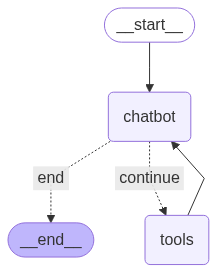

In [17]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [19]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "What's the weather in Tokyo?")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "What’s trending in Paris fashion?")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "Multiply 7 and 8")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "Add 10 + 2 * 3")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (568c998b-1c6d-4082-8ca8-5df4ddb826ad)
 Call ID: 568c998b-1c6d-4082-8ca8-5df4ddb826ad
  Args:
    a: 40.0
    b: 12.0
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  multiply (357e7fbb-9f9a-44c9-9c80-bbb85213e693)
 Call ID: 357e7fbb-9f9a-44c9-9c80-bbb85213e693
  Args:
    a: 52.0
    b: 6.0
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

Okay, 40 + 12 equals 52, and 52 multiplied by 6 equals 312.

Here's a joke for you: Why don't scientists trust atoms? Because t

In [20]:
from langchain_core.messages import HumanMessage
conversation_history = []

while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break
    conversation_history.append(HumanMessage(content=user_input))

    inputs = {"messages": conversation_history}

    stream = app.stream(inputs, stream_mode="values")

    for step in stream:
        messages = step["messages"]
        last_msg = messages[-1]
        conversation_history = messages
        if hasattr(last_msg, "content") and last_msg.content:
            print(f"AI: {last_msg.content}")


You: Hey, I am steve
AI: Hey, I am steve
AI: Hey Steve! How can I help you today?
You: weather in tokyo
AI: weather in tokyo
AI: In tokyo, the current weather is as follows:
Detailed status: broken clouds
Wind speed: 7.2 m/s, direction: 360°
Humidity: 52%
Temperature: 
  - Current: 18.38°C
  - High: 18.79°C
  - Low: 17.01°C
  - Feels like: 17.63°C
Rain: {}
Heat index: None
Cloud cover: 75%
AI: OK. The current weather in Tokyo is: Detailed status: broken clouds, Wind speed: 7.2 m/s, direction: 360°, Humidity: 52%, Temperature: Current: 18.38°C, High: 18.79°C, Low: 17.01°C, Feels like: 17.63°C, Cloud cover: 75%.
You: fashion trend in tokyo
AI: fashion trend in tokyo
AI: Oversized techwear sneakers
AI: I recommend oversized techwear sneakers.
You: 10*9*7+9-10
AI: 10*9*7+9-10
AI: 629
AI: 10*9*7+9-10 = 629
You: thanks
AI: thanks
AI: You're welcome! Is there anything else I can help you with today?
You: exit


#Level - 4(tried)


In [21]:
researcher_tools = []
analyst_tools = [add, subtract, multiply, evaluate_expression]
decision_maker_tools = [fashion_recommender, weather_tool]

In [22]:
os.environ["GOOGLE_API_KEY"] = getpass("Enter your Gemini API key: ")
base_model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

Enter your Gemini API key: ··········


In [23]:
researcher_model = base_model.bind_tools(researcher_tools)
analyst_model = base_model.bind_tools(analyst_tools)
decision_maker_model = base_model.bind_tools(decision_maker_tools)

In [24]:
def researcher_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are a Researcher AI.")
    messages = [system_prompt] + [msg for msg in state["messages"] if hasattr(msg, 'content') and msg.content]
    response = researcher_model.invoke(messages)
    return {"messages": state["messages"] + [response]}

def analyst_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are an Analyst AI. Handle math and calculations.")
    messages = [system_prompt] + [msg for msg in state["messages"] if hasattr(msg, 'content') and msg.content]
    response = analyst_model.invoke(messages)
    return {"messages": state["messages"] + [response]}

def decision_maker_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are a Decision Maker AI. Provide weather and fashion advice.")
    messages = [system_prompt] + [msg for msg in state["messages"] if hasattr(msg, 'content') and msg.content]
    response = decision_maker_model.invoke(messages)
    return {"messages": state["messages"] + [response]}

In [25]:
def route_agent(state: AgentState) -> str:
    last_message = state["messages"][-1]
    user_text = last_message.content.lower()

    if any(word in user_text for word in ["add", "subtract", "multiply", "calculate", "evaluate","*","-","+"]):
        return "analyst"
    elif any(word in user_text for word in ["weather", "temperature", "forecast", "fashion", "trend", "trending"]):
        return "decision_maker"
    else:
        return "researcher"

In [26]:
graph = StateGraph(AgentState)

graph.add_node("researcher", researcher_agent)
graph.add_node("analyst", analyst_agent)
graph.add_node("decision_maker", decision_maker_agent)

In [27]:
def should_continue(state: AgentState):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"
    return "end"

In [28]:
agent_functions = {
    "analyst": analyst_agent,
    "decision_maker": decision_maker_agent,
    "researcher": researcher_agent
}
def entry_point(state: AgentState) -> AgentState:
    last_message = state["messages"][-1]
    if not getattr(last_message, "content", "").strip():
        return state

    agent_key = route_agent(state)
    return agent_functions[agent_key](state)

graph.add_node("entry", entry_point)
graph.set_entry_point("entry")

In [29]:
graph.add_conditional_edges("entry", route_agent, {
    "researcher": "researcher",
    "analyst": "analyst",
    "decision_maker": "decision_maker"
})


In [30]:
graph.add_conditional_edges("researcher", should_continue,
 {
    "continue": "researcher",
    "end": END
    })
graph.add_conditional_edges("analyst", should_continue,
 {
     "continue": "analyst",
     "end": END
     })
graph.add_conditional_edges("decision_maker", should_continue,
 {
     "continue": "decision_maker",
     "end": END
  })

app = graph.compile()

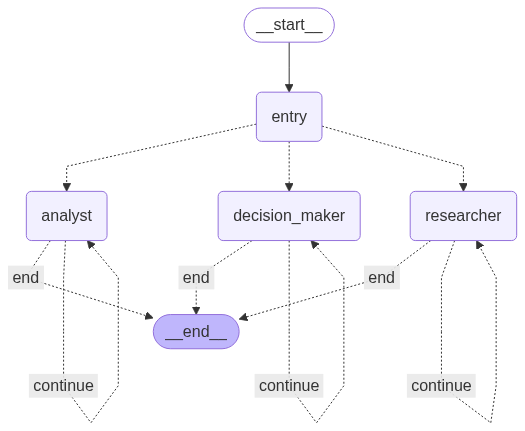

In [31]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [32]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [33]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "What's the weather in Tokyo?")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "What’s trending in Paris fashion?")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "Multiply 7 and 8")]}
print_stream(app.stream(inputs, stream_mode="values"))

inputs = {"messages": [("user", "Add 10 + 2 * 3")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (a19ecb53-2948-476e-8111-72ef2a0ac36c)
 Call ID: a19ecb53-2948-476e-8111-72ef2a0ac36c
  Args:
    a: 40.0
    b: 12.0
================================== Ai Message ==================================

Okay, I can do that!

*   40 + 12 = 52
*   52 x 6 = 312

So, the answer is 312.

Here's a joke for you:

Why don't scientists trust atoms?

Because they make up everything!
================================ Human Message =================================

What's the weather in Tokyo?
================================== Ai Message ==================================
Tool Calls:
  open_weather_map (6ad8a46d-e78a-4a94-bca4-ae0193ec015a)
 Call ID: 6ad8a46d-e78a-4a94-bca4-ae0193ec015a
  Args:
    location: Tokyo
==================================